In [2]:
import sys

sys.path.append("..")

In [3]:
import torch
from models.transformer import Transformer
from ml_collections import ConfigDict
import torch.nn.functional as F
import glob
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from rfcutils2 import qpsk_matched_filter_demod
import pickle

2024-03-11 11:47:44.085258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 11:47:44.729315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-11 11:47:44.729384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-03-11 11:47:44.729391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
checkpoint = torch.load(
    "/home/tejasj/data2/RF_transformer/checkpoints/qpsk_ofdm_qpsk_simple/weights.pt"
)

config = ConfigDict(checkpoint["cfg"])
model = Transformer(**config.model_config[1]).to(DEVICE)
model.load_state_dict(checkpoint["model"])

Number of parameters: 198.92M


<All keys matched successfully>

In [7]:
class RFDatasetBase(Dataset):
    def __init__(
        self,
        soi_root_dir: str,
        interference_root_dir: str,
        window_size: int,
        context_size: int,
    ):
        self.soi_root_dir = soi_root_dir
        self.interference_root_dir = interference_root_dir
        self.window_size = window_size
        self.context_size = context_size

        self.soi_files = glob.glob(os.path.join(soi_root_dir, "*.npy"))
        self.interference_files = glob.glob(
            os.path.join(interference_root_dir, "*.npy")
        )

    def __len__(self):
        return len(self.soi_files)

    def __getitem__(self, idx):
        soi = torch.view_as_real(torch.from_numpy(np.load(self.soi_files[idx]))).to(
            torch.float32
        )
        interference = torch.view_as_real(
            torch.from_numpy(np.load(self.interference_files[idx]))
        ).to(torch.float32)

        min_length = min(soi.shape[0], interference.shape[0])
        sequence_length = (min_length // self.window_size) * self.window_size

        soi = soi[:sequence_length]
        interference = interference[:sequence_length]

        soi_target = soi.unfold(0, self.window_size, self.window_size).reshape(
            -1, self.window_size * 2
        )

        soi = F.pad(soi, (0, 0, self.context_size, 0))
        interference = F.pad(interference, (0, 0, self.context_size, 0))
        soi_windows = soi.unfold(
            0, self.context_size + self.window_size, self.window_size
        ).reshape(-1, (self.window_size + self.context_size) * 2)
        interference_windows = interference.unfold(
            0, self.context_size + self.window_size, self.window_size
        ).reshape(-1, (self.window_size + self.context_size) * 2)

        assert (
            soi_windows.shape[0] == interference_windows.shape[0] == soi_target.shape[0]
        ), (
            soi_windows.shape,
            interference_windows.shape,
            soi_target.shape,
        )

        return {
            "soi": soi_windows,
            "interference": interference_windows,
            "target": soi_target,
        }

In [8]:
dataset = RFDatasetBase(
    soi_root_dir="/home/tejasj/data2/RF_transformer/dataset/qpsk/test_qpsk_100_160",
    interference_root_dir="/home/tejasj/data2/RF_transformer/dataset/ofdm/test_ofdm_100_32",
    window_size=128,
    context_size=32,
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=10,
    shuffle=False,
    pin_memory=True,
)

In [9]:
ALL_SINR = [-3, -6, -9, -12, -15, -18, -21, -24]

all_mse_loss = []
all_ber = []

for sinr in ALL_SINR:
    coeff = coeff = 10 ** (-0.5 * sinr / 10)

    all_mse_loss.append([])
    all_ber.append([])

    for sample in tqdm(dataloader):
        soi = sample["soi"]
        interference = sample["interference"]
        target = sample["target"]

        soi = soi.to(DEVICE)
        interference = interference.to(DEVICE)
        target = target.to(DEVICE)

        mixture = soi + coeff * interference

        preds = model.generate(
            cond=model.embed_patch(mixture),
            window_size=128,
            context_size=32,
        )

        for i in range(preds.shape[0]):
            target_waveform = torch.view_as_complex(
                target[i].cpu().reshape(-1, 2, 128).transpose(1, 2).contiguous()
            ).numpy()
            target_waveform = np.concatenate(
                [target_waveform[i] for i in range(target_waveform.shape[0])], axis=-1
            )
            preds_waveform = torch.view_as_complex(
                preds[i].cpu().reshape(-1, 2, 128).transpose(1, 2).contiguous()
            ).numpy()
            preds_waveform = np.concatenate(
                [preds_waveform[i] for i in range(preds_waveform.shape[0])], axis=-1
            )

            target_bits, target_soi = qpsk_matched_filter_demod(target_waveform)
            preds_bits, preds_soi = qpsk_matched_filter_demod(preds_waveform)

            mse = np.mean(np.abs(target_waveform - preds_waveform) ** 2)
            ber = np.mean((target_bits.numpy() != preds_bits.numpy()).astype(np.float32))

            all_mse_loss[-1].append(mse)
            all_ber[-1].append(ber)

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


In [10]:
all_mse_lmmse, all_mse_unet, all_ber_mf, all_ber_lmmse, all_ber_unet = pickle.load(open('qpsk_ofdm_qpsk_baselines_0501.pkl', 'rb'))
all_mse_unet = 10 * np.log10(np.array(all_mse_unet).reshape(-1, 100).mean(axis=-1))
all_ber_unet = np.array(all_ber_unet).reshape(-1, 100).mean(axis=-1)

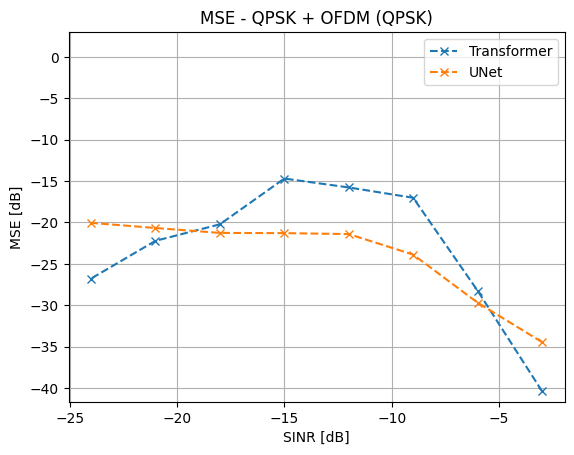

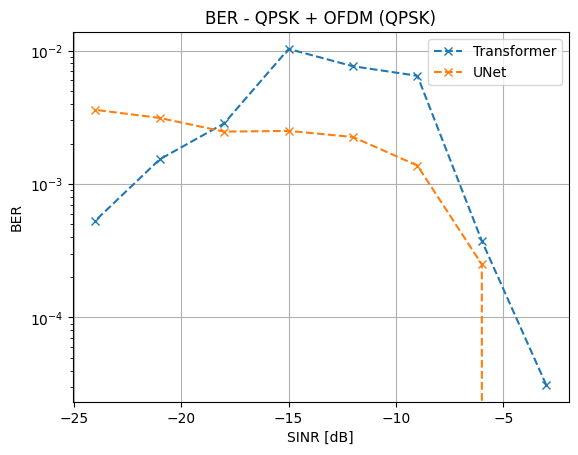

In [11]:
import matplotlib.pyplot as plt

processed_mse = [10 * np.log10(sum(all_mse_loss[i]) / len(all_mse_loss[i])) for i in range(len(all_mse_loss))]
processed_ber = [sum(all_ber[i]) / len(all_ber[i]) for i in range(len(all_ber))]

fig, ax = plt.subplots()
ax.plot(ALL_SINR, processed_mse, 'x--', label="Transformer")
ax.plot(ALL_SINR, all_mse_unet, 'x--', label="UNet")
plt.legend()
plt.grid()
plt.gca().set_ylim(top=3)
plt.xlabel('SINR [dB]')
plt.ylabel('MSE [dB]')
plt.title('MSE - QPSK + OFDM (QPSK)')
plt.show()

fig, ax = plt.subplots()
ax.semilogy(ALL_SINR, processed_ber, 'x--', label="Transformer")
ax.semilogy(ALL_SINR, all_ber_unet, 'x--', label="UNet")
plt.legend()
plt.grid()
plt.xlabel('SINR [dB]')
plt.ylabel('BER')
plt.title('BER - QPSK + OFDM (QPSK)')
plt.show()